#### 주요 기능

1. 학습 및 콘텐츠 제작:
    - GenAI에 대한 맞춤형 학습 경로를 제공하며, 주요 주제와 기술을 다룹니다.
    - 사용자의 관심사나 문의 사항을 기반으로 튜토리얼, 블로그, 게시물을 제작할 수 있도록 지원.

2. Q&A 지원:
    - 개념이나 코딩 문제에 대한 도움이 필요한 사용자를 위해 온디맨드 Q&A 세션을 제공.

3. 이력서 작성 및 검토:
    - 일대일 이력서 컨설팅 및 지도를 제공.
    - 최신 채용 트렌드에 최적화된 맞춤형 시장 관련 이력서를 작성.

4. 면접 준비:
    - 일반적인 면접 질문 및 기술 면접 질문에 대한 Q&A 세션을 진행.
    - 실제 면접 시나리오를 시뮬레이션하고 모의 면접을 진행.

5. 구직 지원:
    - 사용자에게 맞춤형 인사이트와 지원을 제공하여 구직 과정을 안내.

#### 주요 구성 요소
- 상태 관리: TypedDict를 사용하여 각 고객 상호작용의 상태를 정의하고 관리합니다.
- 쿼리 분류: 사용자 쿼리를 학습, 이력서 작성, 면접 또는 구직 활동으로 분류합니다.
- 하위 분류: 학습(튜토리얼, Q&A), 면접(면접 준비, 모의 면접)
- 응답 생성: 쿼리 범주에 따라 적절한 응답을 생성합니다. 튜토리얼 블로그, 이력서, 모의 면접 등을 위한 .md 파일을 생성합니다.
- 워크플로 그래프: LangGraph를 활용하여 유연하고 확장 가능한 워크플로를 생성합니다.

#### 메서드 세부 정보

- 초기화: 환경을 설정하고 필요한 라이브러리를 가져옵니다.
- 상태 정의: 쿼리 정보, 범주, 하위 범주 및 응답을 보관하는 구조를 생성합니다.
- 노드 함수: 범주화 및 응답 생성을 위한 별도의 함수를 구현합니다.
- 그래프 생성: StateGraph를 사용하여 워크플로를 정의하고, 지원 프로세스를 나타내는 노드와 간선을 추가합니다.
- 조건부 라우팅: 범주 및 하위 범주를 기반으로 쿼리를 라우팅하는 로직을 구현합니다.
- 워크플로 컴파일: 그래프를 실행 가능한 애플리케이션으로 컴파일합니다.
- 실행: 워크플로를 통해 사용자 쿼리를 처리하고 결과를 검색합니다.

In [1]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
llm = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)

In [2]:
class State(TypedDict):
    query: str
    category: str
    response: str

- `trim_conversation 함수`: 이 함수는 대화 기록을 최신 메시지(최대 10개)로 제한하여 최근 관련 메시지만 프롬프트에 보관되도록 합니다.

- `save_file 함수`: Agent_output 폴더에 고유한 타임스탬프가 지정된 마크다운 파일로 데이터를 저장하고, 폴더가 없으면 새로 생성합니다.

- `show_md_file 함수`: 노트북 내의 마크다운 파일 내용을 읽고 표시하며, 가독성을 고려하여 마크다운 형식으로 렌더링합니다.

In [3]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages

def trim_conversation(prompt):
    """Trims conversation history to retain only the latest messages within the limit."""
    max_messages = 10  # Limit the conversation history to the latest 10 messages
    return trim_messages(
        prompt,
        max_tokens=max_messages,  # Specifies the maximum number of messages allowed
        strategy="last",  # Trimming strategy to keep the last messages
        token_counter=len,  # Counts tokens/messages using the length of the list
        start_on="human",  # Start trimming when reaching the first human message
        include_system=True,  # Include system messages in the trimmed history
        allow_partial=False,  # Ensures only whole messages are included
    )

import os
from datetime import datetime

def save_file(data, filename):
    """Saves data to a markdown file with a timestamped filename."""
    folder_name = "example03"  # Folder to store output files
    os.makedirs(folder_name, exist_ok=True)  # Creates the folder if it doesn't exist
    
    # Generate a timestamped filename for uniqueness
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")  # Format: YYYYMMDDHHMMSS
    filename = f"{filename}_{timestamp}.md"
    
    # Define the full file path
    file_path = os.path.join(folder_name, filename)
    
    # Save the data to the file in the specified path
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(data)
        print(f"File '{file_path}' created successfully.")
    
    # Return the full path of the saved file
    return file_path

def show_md_file(file_path):
    """Displays the content of a markdown file as Markdown in the notebook."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Render the content in Markdown format within the notebook
    display(Markdown(content))

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_tavily import TavilySearch
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

In [5]:
class LearningResourceAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tools
        self.model = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
        self.prompt = prompt
        self.tools = [TavilySearch()]

    def TutorialAgent(self, user_input):
        # Set up an agent with tool access and execute a tutorial-style response
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"input": user_input})
        
        # Save and display the response as a markdown file
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Tutorial')
        print(f"Tutorial saved to {path}")
        return path

    def QueryBot(self, user_input):
        # Initiates a Q&A loop for continuous interaction with the user
        print("\nStarting the Q&A session. Type 'exit' to end the session.\n")
        record_QA_session = []
        record_QA_session.append('User Query: %s \n' % user_input)
        self.prompt.append(HumanMessage(content=user_input))
        while True:
            # Trim conversation history to maintain prompt size
            self.prompt = trim_conversation(self.prompt)
            
            # Generate a response from the AI model and update conversation history
            response = self.model.invoke(self.prompt)
            record_QA_session.append('\nExpert Response: %s \n' % response.content)
            
            self.prompt.append(AIMessage(content=response.content))
            
            # Display the AI's response and prompt for user input
            print('*' * 50 + 'AGENT' + '*' * 50)
            print("\nEXPERT AGENT RESPONSE:", response.content)
            
            print('*' * 50 + 'USER' + '*' * 50)
            user_input = input("\nYOUR QUERY: ")
            record_QA_session.append('\nUser Query: %s \n' % response.content)
            self.prompt.append(HumanMessage(content=user_input))
            
            # Exit the Q&A loop if the user types 'exit'
            if user_input.lower() == "exit":
                print("Ending the chat session.")
                path = save_file(''.join(record_QA_session),'Q&A_Doubt_Session')
                print(f"Q&A Session saved to {path}")
                return path

In [6]:
class InterviewAgent:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for use in the agent
        self.model = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
        self.prompt = prompt
        self.tools = [TavilySearch()]

    def Interview_questions(self, user_input):
        # Holds the conversation history and cumulative questions and answers
        chat_history = []
        questions_bank = ''
        # Create an agent executor with tool access and enable verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)
        while True:
            print("\nStarting the Interview question preparation. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to the user input and add it to questions_bank
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            questions_bank += str(response.get('output')).replace("```markdown", "").strip() + "\n"
            
            # Update chat history with user input and AI response, limiting history to the last 10 messages
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]  # Keep only the last 10 messages
            
            # Get the next input from the user to continue the conversation
            user_input = input("You: ")
        
        # Save the entire question-response history to a markdown file and display it
        path = save_file(questions_bank, 'Interview_questions')
        print(f"Interviews question saved to {path}")
        return path

    def Mock_Interview(self):
        # Start a simulated mock interview session
        print("\nStarting the mock interview. Type 'exit' to end the session.\n")
        
        # Initialize with a starting message and store interview records
        initial_message = 'I am ready for the interview.\n'
        interview_record = []
        interview_record.append('Candidate: %s \n' % initial_message)
        self.prompt.append(HumanMessage(content=initial_message))
        
        while True:
            # Trim conversation history if necessary to maintain prompt size
            self.prompt = trim_conversation(self.prompt)
            
            # Generate a response using the chat model
            response = self.model.invoke(self.prompt)
            
            # Add AI response to the conversation history
            self.prompt.append(AIMessage(content=response.content))
            
            # Output the AI's response as the "Interviewer"
            print("\nInterviewer:", response.content)
            interview_record.append('\nInterviewer: %s \n' % response.content)
            
            # Get the user's response as "Candidate" input
            user_input = input("\nCandidate: ")
            interview_record.append('\nCandidate: %s \n' % user_input)
            
            # Add user input to the conversation history
            self.prompt.append(HumanMessage(content=user_input))
            
            # End the interview if the user types "exit"
            if user_input.lower() == "exit":
                print("Ending the interview session.")
                path = save_file(''.join(interview_record),'Mock_Interview')
                print(f"Mock Interview saved to {path}")
                return path

In [7]:
class ResumeMaker:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for resume creation
        self.model = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
        self.prompt = prompt
        self.tools = [TavilySearch()]
        # Create an agent executor with tool access, enabling verbose output and error handling
        self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def Create_Resume(self, user_input):
        # Maintain chat history for the resume creation conversation
        chat_history = []
        while True:
            print("\nStarting the Resume create session. Type 'exit' to end the session.\n")
            if user_input.lower() == "exit":
                print("Ending the conversation. Goodbye!")
                break
            
            # Generate a response to user input using the agent and add it to the chat history
            response = self.agent_executor.invoke({"input": user_input, "chat_history": chat_history})
            chat_history.extend([HumanMessage(content=user_input), response["output"]])
            
            # Limit the chat history to the last 10 messages
            if len(chat_history) > 10:
                chat_history = chat_history[-10:]
            
            # Prompt for the next user input to continue the resume creation conversation
            user_input = input("You: ")
        
        # Save the final output as a markdown file and return the file path
        path = save_file(str(response.get('output')).replace("```markdown", "").strip(), 'Resume')
        print(f"Resume saved to {path}")
        return path

In [8]:
class JobSearch:
    def __init__(self, prompt):
        # Initialize the chat model, prompt template, and search tool for job search assistance
        self.model = ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
        self.prompt = prompt
        self.tools = TavilySearch()
        # Create an agent executor with tool access, enabling verbose output and error handling
        # self.agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        # self.agent_executor = AgentExecutor(agent=self.agent, tools=self.tools, verbose=True, handle_parsing_errors=True)

    def find_jobs(self, user_input):
        results = self.tools.invoke(user_input)
        chain = self.prompt | self.model  
        jobs = chain.invoke({"result": results}).content
        
        path = save_file(str(jobs).replace("```markdown", "").strip(), 'Job_search')
        print(f"Jobs saved to {path}")
        return path

In [9]:
def categorize(state: State) -> State:
    """Categorizes the user query into one of four main categories: Learn Generative AI Technology, Resume Making, Interview Preparation, or Job Search."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories:\n"
        "1: Learn Generative AI Technology\n"
        "2: Resume Making\n"
        "3: Interview Preparation\n"
        "4: Job Search\n"
        "Give the number only as an output.\n\n"
        "Examples:\n"
        "1. Query: 'What are the basics of generative AI, and how can I start learning it?' -> 1\n"
        "2. Query: 'Can you help me improve my resume for a tech position?' -> 2\n"
        "3. Query: 'What are some common questions asked in AI interviews?' -> 3\n"
        "4. Query: 'Are there any job openings for AI engineers?' -> 4\n\n"
        "Now, categorize the following customer query:\n"
        "Query: {query}"
    )

    # Creates a categorization chain and invokes it with the user's query to get the category
    chain = prompt | llm 
    print('Categorizing the customer query...')
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def handle_learning_resource(state: State) -> State:
    """Determines if the query is related to Tutorial creation or general Questions on generative AI topics."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Tutorial: For queries related to creating tutorials, blogs, or documentation on generative AI.\n"
        "- Question: For general queries asking about generative AI topics.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'How to create a blog on prompt engineering for generative AI?' -> Category: Tutorial\n"
        "2. User query: 'Can you provide a step-by-step guide on fine-tuning a generative model?' -> Category: Tutorial\n"
        "3. User query: 'Provide me the documentation for Langchain?' -> Category: Tutorial\n"
        "4. User query: 'What are the main applications of generative AI?' -> Category: Question\n"
        "5. User query: 'Is there any generative AI course available?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Tutorial or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

def handle_interview_preparation(state: State) -> State:
    """Determines if the query is related to Mock Interviews or general Interview Questions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories:\n\n"
        "Categories:\n"
        "- Mock: For requests related to mock interviews.\n"
        "- Question: For general queries asking about interview topics or preparation.\n"
        "- Default to Question if the query doesn't fit either of these categories.\n\n"
        "Examples:\n"
        "1. User query: 'Can you conduct a mock interview with me for a Gen AI role?' -> Category: Mock\n"
        "2. User query: 'What topics should I prepare for an AI Engineer interview?' -> Category: Question\n"
        "3. User query: 'I need to practice interview focused on Gen AI.' -> Category: Mock\n"
        "4. User query: 'Can you list important coding topics for AI tech interviews?' -> Category: Question\n\n"
        "Now, categorize the following user query:\n"
        "The user query is: {query}\n"
    )

    # Creates a further categorization chain to decide between Mock or Question
    chain = prompt | llm 
    print('Categorizing the customer query further...')
    response = chain.invoke({"query": state["query"]}).content
    return {"category": response}

In [10]:
def job_search(state: State) -> State:
    """Provide a job search response based on user query requirements."""
    prompt = ChatPromptTemplate.from_template('''Your task is to refactor and make .md file for the this content which includes
    the jobs available in the market. Refactor such that user can refer easily. Content: {result}''')
    jobSearch = JobSearch(prompt)
    state["query"] = input('Please make sure to mention Job location you want,Job roles\n')
    path = jobSearch.find_jobs(state["query"])
    show_md_file(path)
    return {"response": path}

def handle_resume_making(state: State) -> State:
    """Generate a customized resume based on user details for a tech role in AI and Generative AI."""
    prompt = ChatPromptTemplate.from_messages([
        ("system", '''You are a skilled resume expert with extensive experience in crafting resumes tailored for tech roles, especially in AI and Generative AI. 
        Your task is to create a resume template for an AI Engineer specializing in Generative AI, incorporating trending keywords and technologies in the current job market. 
        Feel free to ask users for any necessary details such as skills, experience, or projects to complete the resume. 
        Try to ask details step by step and try to ask all details within 4 to 5 steps.
        Ensure the final resume is in .md format.'''),
       MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ])
    resumeMaker = ResumeMaker(prompt)
    path = resumeMaker.Create_Resume(state["query"])
    show_md_file(path)
    return {"response": path}

In [11]:
def ask_query_bot(state: State) -> State:
    """Provide detailed answers to user queries related to Generative AI."""
    system_message = '''You are an expert Generative AI Engineer with extensive experience in training and guiding others in AI engineering. 
    You have a strong track record of solving complex problems and addressing various challenges in AI. 
    Your role is to assist users by providing insightful solutions and expert advice on their queries.
    Engage in a back-and-forth chat session to address user queries.'''
    prompt = [SystemMessage(content=system_message)]

    learning_agent = LearningResourceAgent(prompt)

    path = learning_agent.QueryBot(state["query"])
    show_md_file(path)
    return {"response": path}

def tutorial_agent(state: State) -> State:
    """Generate a tutorial blog for Generative AI based on user requirements."""
    system_message = '''You are a knowledgeable assistant specializing as a Senior Generative AI Developer with extensive experience in both development and tutoring. 
         Additionally, you are an experienced blogger who creates tutorials focused on Generative AI.
         Your task is to develop high-quality tutorials blogs in .md file with Coding example based on the user's requirements. 
         Ensure tutorial includes clear explanations, well-structured python code, comments, and fully functional code examples.
         Provide resource reference links at the end of each tutorial for further learning.'''
    prompt = ChatPromptTemplate.from_messages([("system", system_message),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])
    #agent_scratchpad is a function that formats the intermediate steps of the agent's actions and observations into a string. 
    #This function is used to keep track of the agent's thoughts or actions during the execution of the program. But its not necessary, we can do without this so we will not include it only define it.
    learning_agent = LearningResourceAgent(prompt)
    path = learning_agent.TutorialAgent(state["query"])
    show_md_file(path)
    return {"response": path}

In [12]:
def interview_topics_questions(state: State) -> State:
    """Provide a curated list of interview questions related to Generative AI based on user input."""
    system_message = '''You are a good researcher in finding interview questions for Generative AI topics and jobs.
                     Your task is to provide a list of interview questions for Generative AI topics and job based on user requirements.
                     Provide top questions with references and links if possible. You may ask for clarification if needed.
                     Generate a .md document containing the questions.'''
    prompt = ChatPromptTemplate.from_messages([
                        ("system", system_message),
                        MessagesPlaceholder("chat_history"),
                        ("human", "{input}"),
                        ("placeholder", "{agent_scratchpad}"),])
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Interview_questions(state["query"])
    show_md_file(path)
    return {"response": path}

def mock_interview(state: State) -> State:
    """Conduct a mock interview for a Generative AI position, including evaluation at the end."""
    system_message = '''You are a Generative AI Interviewer. You have conducted numerous interviews for Generative AI roles.
         Your task is to conduct a mock interview for a Generative AI position, engaging in a back-and-forth interview session.
         The conversation should not exceed more than 15 to 20 minutes.
         At the end of the interview, provide an evaluation for the candidate.'''
    prompt = [SystemMessage(content=system_message)]
    interview_agent = InterviewAgent(prompt)
    path = interview_agent.Mock_Interview()
    show_md_file(path)
    return {"response": path}

In [13]:
def route_query(state: State):
    """Route the query based on its category to the appropriate handler."""
    if '1' in state["category"]:
        print('Category: handle_learning_resource')
        return "handle_learning_resource"  # Directs queries about learning generative AI to the learning resource handler
    elif '2' in state["category"]:
        print('Category: handle_resume_making')
        return "handle_resume_making"  # Directs queries about resume making to the resume handler
    elif '3' in state["category"]:
        print('Category: handle_interview_preparation')
        return "handle_interview_preparation"  # Directs queries about interview preparation to the interview handler
    elif '4' in state["category"]:
        print('Category: job_search')
        return "job_search"  # Directs job search queries to the job search handler
    else:
        print("Please ask your question based on my description.")
        return False  # Returns False if the category does not match any predefined options

def route_interview(state: State) -> str:
    """Route the query to the appropriate interview-related handler."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: interview_topics_questions')
        return "interview_topics_questions"  # Directs to the handler for interview topic questions
    elif 'Mock'.lower() in state["category"].lower():
        print('Category: mock_interview')
        return "mock_interview"  # Directs to the mock interview handler
    else:
        print('Category: mock_interview')
        return "mock_interview"  # Defaults to mock interview if category does not clearly match

def route_learning(state: State):
    """Route the query based on the learning path category."""
    if 'Question'.lower() in state["category"].lower():
        print('Category: ask_query_bot')
        return "ask_query_bot"  # Directs queries to the general question bot
    elif 'Tutorial'.lower() in state["category"].lower():
        print('Category: tutorial_agent')
        return "tutorial_agent"  # Directs queries to the tutorial creation agent
    else:
        print("Please ask your question based on my interview description.")
        return False  # Returns False if no clear category match is found

In [14]:
# Create the workflow graph
workflow = StateGraph(State)

# Add nodes for each state in the workflow
workflow.add_node("categorize", categorize)  # Initial categorization node
workflow.add_node("handle_learning_resource", handle_learning_resource)  # Handles learning-related queries
workflow.add_node("handle_resume_making", handle_resume_making)  # Handles resume-making queries
workflow.add_node("handle_interview_preparation", handle_interview_preparation)  # Handles interview prep queries
workflow.add_node("job_search", job_search)  # Handles job search queries
workflow.add_node("mock_interview", mock_interview)  # Handles mock interview sessions
workflow.add_node("interview_topics_questions", interview_topics_questions)  # Handles interview topic questions
workflow.add_node("tutorial_agent", tutorial_agent)  # Tutorial agent for generative AI learning resources
workflow.add_node("ask_query_bot", ask_query_bot)  # General query bot for learning resources

# Define the starting edge to the categorization node
workflow.add_edge(START, "categorize")

# Add conditional edges based on category routing function
workflow.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_learning_resource": "handle_learning_resource",
        "handle_resume_making": "handle_resume_making",
        "handle_interview_preparation": "handle_interview_preparation",
        "job_search": "job_search"
    }
)

# Add conditional edges for further routing in interview preparation
workflow.add_conditional_edges(
    "handle_interview_preparation",
    route_interview,
    {
        "mock_interview": "mock_interview",
        "interview_topics_questions": "interview_topics_questions",
    }
)

# Add conditional edges for further routing in learning resources
workflow.add_conditional_edges(
    "handle_learning_resource",
    route_learning,
    {
        "tutorial_agent": "tutorial_agent",
        "ask_query_bot": "ask_query_bot",
    }
)

# Define edges that lead to the end of the workflow
workflow.add_edge("handle_resume_making", END)
workflow.add_edge("job_search", END)
workflow.add_edge("interview_topics_questions", END)
workflow.add_edge("mock_interview", END)
workflow.add_edge("ask_query_bot", END)
workflow.add_edge("tutorial_agent", END)

# Set the initial entry point to start the workflow at the categorize node
workflow.set_entry_point("categorize")

# Compile the workflow graph into an application
app = workflow.compile()

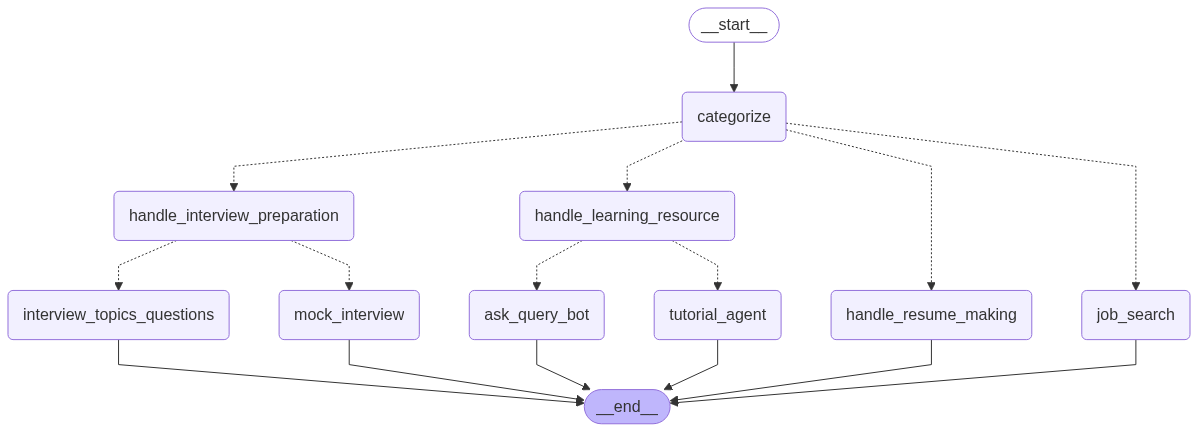

In [15]:
# Display the workflow graph as a PNG image using Mermaid
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

In [16]:
def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "response": results["response"]
    }

In [ ]:
query = "langchain과 langgraph를 배우고 싶습니다. 사용법과 개념을 익히고, 두 가지 모두에 대한 코딩 예제를 제공하고, 이를 위한 튜토리얼을 제작하고 싶습니다."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: tutorial_agent


> Entering new AgentExecutor chain...
아래는 LangChain과 LangGraph의 개념, 사용법, 그리고 각각의 Python 코딩 예제를 포함한 튜토리얼 블로그 포스트입니다.  
튜토리얼은 Markdown(.md) 형식으로 작성되어 있으며, 각 단계별로 친절한 설명과 주석이 포함되어 있습니다.

---

# LangChain & LangGraph 튜토리얼: 개념, 사용법, 그리고 실습 예제

## 목차
1. [LangChain이란?](#langchain이란)
2. [LangChain 기본 사용법 및 예제](#langchain-기본-사용법-및-예제)
3. [LangGraph란?](#langgraph란)
4. [LangGraph 기본 사용법 및 예제](#langgraph-기본-사용법-및-예제)
5. [참고 자료](#참고-자료)

---

## LangChain이란?

**LangChain**은 LLM(Large Language Model) 기반 애플리케이션을 쉽고 빠르게 개발할 수 있도록 도와주는 Python 프레임워크입니다.  
주요 특징은 다음과 같습니다.

- LLM, 프롬프트, 체인, 에이전트, 툴 등 다양한 컴포넌트 제공
- 외부 데이터(문서, DB, API 등)와의 연동이 쉬움
- 체인(Chain) 구조로 복잡한 워크플로우를 구성 가능

### 주요 개념

- **LLM**: OpenAI, HuggingFace 등 다양한 LLM을 래핑하여 사용
- **PromptTemplate**: 프롬프트를 템플릿화하여 동적으로 생성
- **Chain**: 여러 단계를 연결하여 복잡한 작업을 수행
- **Agent**: 툴을 사용해 동적으로 행동을 결정하는 LLM 기반 시스템

---

#

아래는 LangChain과 LangGraph의 개념, 사용법, 그리고 각각의 Python 코딩 예제를 포함한 튜토리얼 블로그 포스트입니다.  
튜토리얼은 Markdown(.md) 형식으로 작성되어 있으며, 각 단계별로 친절한 설명과 주석이 포함되어 있습니다.

---

# LangChain & LangGraph 튜토리얼: 개념, 사용법, 그리고 실습 예제

## 목차
1. [LangChain이란?](#langchain이란)
2. [LangChain 기본 사용법 및 예제](#langchain-기본-사용법-및-예제)
3. [LangGraph란?](#langgraph란)
4. [LangGraph 기본 사용법 및 예제](#langgraph-기본-사용법-및-예제)
5. [참고 자료](#참고-자료)

---

## LangChain이란?

**LangChain**은 LLM(Large Language Model) 기반 애플리케이션을 쉽고 빠르게 개발할 수 있도록 도와주는 Python 프레임워크입니다.  
주요 특징은 다음과 같습니다.

- LLM, 프롬프트, 체인, 에이전트, 툴 등 다양한 컴포넌트 제공
- 외부 데이터(문서, DB, API 등)와의 연동이 쉬움
- 체인(Chain) 구조로 복잡한 워크플로우를 구성 가능

### 주요 개념

- **LLM**: OpenAI, HuggingFace 등 다양한 LLM을 래핑하여 사용
- **PromptTemplate**: 프롬프트를 템플릿화하여 동적으로 생성
- **Chain**: 여러 단계를 연결하여 복잡한 작업을 수행
- **Agent**: 툴을 사용해 동적으로 행동을 결정하는 LLM 기반 시스템

---

## LangChain 기본 사용법 및 예제

### 1. 설치

```bash
pip install langchain openai
```

### 2. 간단한 LLM 체인 예제

아래 예제는 OpenAI의 GPT-3.5를 사용하여 간단한 질문-답변 체인을 만드는 코드입니다.

```python
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# OpenAI API 키 설정 (환경변수로 설정 권장)
import os
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# 1. LLM 객체 생성
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# 2. 프롬프트 템플릿 생성
prompt = PromptTemplate(
    input_variables=["question"],
    template="Q: {question}\nA:"
)

# 3. LLMChain 생성
chain = LLMChain(llm=llm, prompt=prompt)

# 4. 체인 실행
question = "LangChain이 무엇인가요?"
response = chain.run({"question": question})

print("질문:", question)
print("답변:", response)
```

#### 코드 설명
- `OpenAI`: LLM 객체 생성
- `PromptTemplate`: 질문을 입력받아 프롬프트 생성
- `LLMChain`: LLM과 프롬프트를 연결하여 체인 구성
- `chain.run`: 실제로 질문을 입력해 답변 생성

---

## LangGraph란?

**LangGraph**는 LangChain의 확장 라이브러리로, LLM 기반 워크플로우를 "그래프" 형태로 설계할 수 있게 해줍니다.  
즉, 복잡한 분기, 조건, 반복, 병렬 처리 등 다양한 워크플로우를 시각적으로 설계하고 실행할 수 있습니다.

### 주요 특징

- 노드(Node)와 엣지(Edge)로 구성된 워크플로우
- 각 노드는 LLM, 체인, 함수 등 다양한 작업을 수행
- 조건 분기, 반복, 병렬 처리 등 복잡한 로직 구현 가능

---

## LangGraph 기본 사용법 및 예제

### 1. 설치

```bash
pip install langgraph
```

### 2. 간단한 그래프 워크플로우 예제

아래 예제는 두 개의 노드(질문 생성, 답변 생성)를 연결한 간단한 그래프를 만듭니다.

```python
from langgraph.graph import StateGraph, END
from langchain.llms import OpenAI

# OpenAI API 키 설정 (환경변수로 설정 권장)
import os
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# 1. LLM 객체 생성
llm = OpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# 2. 노드 함수 정의
def generate_question(state):
    # state는 딕셔너리 형태
    state["question"] = "LangGraph의 장점은 무엇인가요?"
    return state

def generate_answer(state):
    question = state["question"]
    answer = llm(f"Q: {question}\nA:")
    state["answer"] = answer
    return state

# 3. 그래프 생성
graph = StateGraph()

# 4. 노드 추가
graph.add_node("generate_question", generate_question)
graph.add_node("generate_answer", generate_answer)

# 5. 엣지(연결) 추가
graph.add_edge("generate_question", "generate_answer")
graph.add_edge("generate_answer", END)  # END는 종료 노드

# 6. 그래프 실행
initial_state = {}
result = graph.run(initial_state)

print("질문:", result["question"])
print("답변:", result["answer"])
```

#### 코드 설명
- `StateGraph`: 그래프 객체 생성
- `add_node`: 각 노드(작업) 추가
- `add_edge`: 노드 간 연결(순서) 정의
- `run`: 그래프 실행, 상태(state) 딕셔너리로 데이터 전달

---

## 참고 자료

- [LangChain 공식 문서](https://python.langchain.com/docs/)
- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)
- [LangChain GitHub](https://github.com/langchain-ai/langchain)
- [LangGraph GitHub](https://github.com/langchain-ai/langgraph)
- [OpenAI API 문서](https://platform.openai.com/docs/)

---

이 튜토리얼을 통해 LangChain과 LangGraph의 기본 개념과 사용법, 그리고 실습 예제를 익힐 수 있습니다.  
더 복잡한 워크플로우나 실제 프로젝트에 적용하고 싶다면 공식 문서와 예제 코드를 참고해보세요!

{'category': 'Category: Tutorial',
 'response': 'Agent_output/Tutorial_20250904131523.md'}

In [ ]:
query = "Langgraph와 CrewAI에서 에이전트 생성 시 언제 무엇을 사용해야 할지 헷갈립니다."
result = run_user_query(query)
print(result)

Categorizing the customer query...
Category: handle_learning_resource
Categorizing the customer query further...
Category: ask_query_bot

Starting the Q&A session. Type 'exit' to end the session.

**************************************************AGENT**************************************************

EXPERT AGENT RESPONSE: 좋은 질문입니다! **LangGraph**와 **CrewAI**는 모두 멀티에이전트 시스템을 구축할 때 사용되는 프레임워크이지만, 목적과 사용 방식에 차이가 있습니다. 각각의 특징과 사용 시점을 비교해서 설명드릴게요.

---

## 1. **LangGraph**
- **주요 목적:**  
  복잡한 대화 흐름, 상태 기반 워크플로우, 분기/루프가 필요한 멀티에이전트 상호작용 설계에 적합합니다.
- **특징:**  
  - 그래프(노드와 엣지) 형태로 에이전트 간의 상호작용을 설계  
  - 각 노드는 에이전트(혹은 함수)  
  - 상태(state)를 기반으로 분기, 반복, 조건부 실행 가능  
  - 대화의 흐름을 세밀하게 제어할 수 있음
- **언제 사용?**  
  - 에이전트 간의 복잡한 상호작용, 조건부 분기, 반복, 상태 추적이 필요한 경우  
  - 예: 고객 상담 챗봇에서 여러 부서(에이전트) 간의 협업, 복잡한 의사결정 트리, 워크플로우 자동화 등

---

## 2. **CrewAI**
- **주요 목적:**  
  여러 에이전트가 협업하여 하나의 목표를 달성하는 태스크 중심의 멀티에이전트 시스템에 적합합니다.
- **특징:**  
  - 각 에이전트가 역할(role)과 전문성(specialty)을 가짐  
  - 태스크를 분할하고, 각 에이전트가 자신의 역할에 따라

User Query: Langgraph와 CrewAI에서 에이전트 생성 시 언제 무엇을 사용해야 할지 헷갈립니다. 

Expert Response: 좋은 질문입니다! **LangGraph**와 **CrewAI**는 모두 멀티에이전트 시스템을 구축할 때 사용되는 프레임워크이지만, 목적과 사용 방식에 차이가 있습니다. 각각의 특징과 사용 시점을 비교해서 설명드릴게요.

---

## 1. **LangGraph**
- **주요 목적:**  
  복잡한 대화 흐름, 상태 기반 워크플로우, 분기/루프가 필요한 멀티에이전트 상호작용 설계에 적합합니다.
- **특징:**  
  - 그래프(노드와 엣지) 형태로 에이전트 간의 상호작용을 설계  
  - 각 노드는 에이전트(혹은 함수)  
  - 상태(state)를 기반으로 분기, 반복, 조건부 실행 가능  
  - 대화의 흐름을 세밀하게 제어할 수 있음
- **언제 사용?**  
  - 에이전트 간의 복잡한 상호작용, 조건부 분기, 반복, 상태 추적이 필요한 경우  
  - 예: 고객 상담 챗봇에서 여러 부서(에이전트) 간의 협업, 복잡한 의사결정 트리, 워크플로우 자동화 등

---

## 2. **CrewAI**
- **주요 목적:**  
  여러 에이전트가 협업하여 하나의 목표를 달성하는 태스크 중심의 멀티에이전트 시스템에 적합합니다.
- **특징:**  
  - 각 에이전트가 역할(role)과 전문성(specialty)을 가짐  
  - 태스크를 분할하고, 각 에이전트가 자신의 역할에 따라 작업  
  - 전체적인 플로우는 Crew(팀) 단위로 관리  
  - 워크플로우는 비교적 직선적(순차적/병렬적)  
- **언제 사용?**  
  - 여러 역할의 에이전트가 협업하여 문서 작성, 코드 리뷰, 리서치 등 하나의 결과물을 만드는 경우  
  - 예: 리서치팀(리서처, 라이터, 에디터)이 협업하여 보고서 작성, 코드 생성 및 리뷰 등

---

## **정리: 선택 기준**
- **복잡한 대화 흐름, 상태 기반 분기/루프, 워크플로우 자동화** → **LangGraph**
- **역할 기반 협업, 태스크 분할, 비교적 단순한 워크플로우** → **CrewAI**

---

### **예시로 이해하기**
- **LangGraph:**  
  "고객이 문의 → 상담봇이 분류 → 기술지원/영업/배송 담당 에이전트로 분기 → 각 담당이 처리 → 필요시 다시 상담봇으로 루프"
- **CrewAI:**  
  "리서치 요청 → 리서처가 조사 → 라이터가 정리 → 에디터가 검토 → 최종 결과물 생성"

---

### **추가 질문**
- 실제로 구현하려는 시나리오나 프로젝트가 있다면, 구체적으로 말씀해주시면 더 맞춤형으로 추천드릴 수 있습니다!  
- 두 프레임워크의 코드 예시나, 장단점 비교도 원하시면 추가로 설명드릴 수 있습니다.

궁금한 점 더 말씀해 주세요! 

User Query: 좋은 질문입니다! **LangGraph**와 **CrewAI**는 모두 멀티에이전트 시스템을 구축할 때 사용되는 프레임워크이지만, 목적과 사용 방식에 차이가 있습니다. 각각의 특징과 사용 시점을 비교해서 설명드릴게요.

---

## 1. **LangGraph**
- **주요 목적:**  
  복잡한 대화 흐름, 상태 기반 워크플로우, 분기/루프가 필요한 멀티에이전트 상호작용 설계에 적합합니다.
- **특징:**  
  - 그래프(노드와 엣지) 형태로 에이전트 간의 상호작용을 설계  
  - 각 노드는 에이전트(혹은 함수)  
  - 상태(state)를 기반으로 분기, 반복, 조건부 실행 가능  
  - 대화의 흐름을 세밀하게 제어할 수 있음
- **언제 사용?**  
  - 에이전트 간의 복잡한 상호작용, 조건부 분기, 반복, 상태 추적이 필요한 경우  
  - 예: 고객 상담 챗봇에서 여러 부서(에이전트) 간의 협업, 복잡한 의사결정 트리, 워크플로우 자동화 등

---

## 2. **CrewAI**
- **주요 목적:**  
  여러 에이전트가 협업하여 하나의 목표를 달성하는 태스크 중심의 멀티에이전트 시스템에 적합합니다.
- **특징:**  
  - 각 에이전트가 역할(role)과 전문성(specialty)을 가짐  
  - 태스크를 분할하고, 각 에이전트가 자신의 역할에 따라 작업  
  - 전체적인 플로우는 Crew(팀) 단위로 관리  
  - 워크플로우는 비교적 직선적(순차적/병렬적)  
- **언제 사용?**  
  - 여러 역할의 에이전트가 협업하여 문서 작성, 코드 리뷰, 리서치 등 하나의 결과물을 만드는 경우  
  - 예: 리서치팀(리서처, 라이터, 에디터)이 협업하여 보고서 작성, 코드 생성 및 리뷰 등

---

## **정리: 선택 기준**
- **복잡한 대화 흐름, 상태 기반 분기/루프, 워크플로우 자동화** → **LangGraph**
- **역할 기반 협업, 태스크 분할, 비교적 단순한 워크플로우** → **CrewAI**

---

### **예시로 이해하기**
- **LangGraph:**  
  "고객이 문의 → 상담봇이 분류 → 기술지원/영업/배송 담당 에이전트로 분기 → 각 담당이 처리 → 필요시 다시 상담봇으로 루프"
- **CrewAI:**  
  "리서치 요청 → 리서처가 조사 → 라이터가 정리 → 에디터가 검토 → 최종 결과물 생성"

---

### **추가 질문**
- 실제로 구현하려는 시나리오나 프로젝트가 있다면, 구체적으로 말씀해주시면 더 맞춤형으로 추천드릴 수 있습니다!  
- 두 프레임워크의 코드 예시나, 장단점 비교도 원하시면 추가로 설명드릴 수 있습니다.

궁금한 점 더 말씀해 주세요! 


{'category': 'Category: Question', 'response': 'Agent_output/Q&A_Doubt_Session_20250904131543.md'}


In [ ]:
query = "저는 Gen AI 직무에 대한 면접 질문에 대해 논의하고 싶습니다."
result = run_user_query(query)
print(result)

Categorizing the customer query...
Category: handle_interview_preparation
Categorizing the customer query further...
Category: interview_topics_questions

Starting the Interview question preparation. Type 'exit' to end the session.



> Entering new AgentExecutor chain...
좋은 선택입니다! Gen AI(Generative AI) 직무는 최근 매우 각광받고 있으며, 면접에서 다루어질 수 있는 주제도 다양합니다. 더 구체적으로 어떤 역할(예: 연구원, 엔지니어, 데이터 사이언티스트, 제품 매니저 등)에 대한 질문을 원하시나요? 아니면 전반적인 Gen AI 관련 면접 질문을 원하시나요?

또한, 다음과 같은 세부 사항도 알려주시면 더욱 맞춤형 질문을 제공할 수 있습니다:

- 경력 수준(신입, 경력, 시니어 등)
- 기술 스택(예: Python, PyTorch, TensorFlow 등)
- 관심 있는 Gen AI 분야(예: LLM, 이미지 생성, 멀티모달 등)

원하시는 방향을 알려주시면, 그에 맞는 면접 질문 리스트와 참고 자료를 .md 문서로 정리해드리겠습니다!

> Finished chain.

Starting the Interview question preparation. Type 'exit' to end the session.



> Entering new AgentExecutor chain...

Invoking: `tavily_search` with `{'query': 'Generative AI engineer interview questions with Python, PyTorch, LangChain experience (mid-level to senior)', 'search_depth': 'advanced'}`


{'query': 'G

좋은 선택입니다! Gen AI(Generative AI) 직무는 최근 매우 각광받고 있으며, 면접에서 다루어질 수 있는 주제도 다양합니다. 더 구체적으로 어떤 역할(예: 연구원, 엔지니어, 데이터 사이언티스트, 제품 매니저 등)에 대한 질문을 원하시나요? 아니면 전반적인 Gen AI 관련 면접 질문을 원하시나요?

또한, 다음과 같은 세부 사항도 알려주시면 더욱 맞춤형 질문을 제공할 수 있습니다:

- 경력 수준(신입, 경력, 시니어 등)
- 기술 스택(예: Python, PyTorch, TensorFlow 등)
- 관심 있는 Gen AI 분야(예: LLM, 이미지 생성, 멀티모달 등)

원하시는 방향을 알려주시면, 그에 맞는 면접 질문 리스트와 참고 자료를 .md 문서로 정리해드리겠습니다!
아래는 "Gen AI 엔지니어" 경력직(중견~시니어) 면접을 위한 질문 리스트입니다. Python, PyTorch, LangChain 등 기술 스택과 AI 분야 전반을 고려하여 작성하였으며, 각 질문에 참고할 만한 링크도 포함하였습니다.

---

# Generative AI Engineer Interview Questions (Python, PyTorch, LangChain)

## 1. 기술 및 이론 기반 질문

- **PyTorch를 사용하여 GAN(Generative Adversarial Network)을 설계하고 학습하는 과정을 설명하세요.**
  - [PyTorch GAN Tutorial](https://mentorcruise.com/questions/pytorch/)
- **GAN 학습 시 발생할 수 있는 mode collapse, training instability 문제를 어떻게 해결할 수 있나요?**
  - [Generative AI Engineer — Interview Questions](https://bgiri-gcloud.medium.com/generative-ai-engineer-interview-questions-and-how-to-prepare-for-interview-3a9dcded1628)
- **Transformer 기반 LLM(예: GPT-3)과 RNN, LSTM의 차이점과 각각의 장단점은 무엇인가요?**
  - [200 Generative AI Questions and Answers](https://www.mylearnnest.com/200-generative-ai-questions-and-answers-for-experienced-in-2025/)
- **대규모 언어 모델(LLM)에서 context window의 역할과 한계는 무엇인가요?**
- **LangChain을 활용한 LLM 파이프라인 구축 경험이 있다면, 주요 컴포넌트와 워크플로우를 설명해 주세요.**
  - [LangChain 공식 문서](https://python.langchain.com/docs/)
- **PyTorch에서 커스텀 데이터셋과 DataLoader를 구현할 때 주의할 점은 무엇인가요?**

## 2. 실무/코딩 및 문제 해결

- **Levenshtein distance(편집 거리)를 효율적으로 계산하는 Python 함수를 작성해보세요.**
  - [Levenshtein distance Python example](https://bgiri-gcloud.medium.com/generative-ai-engineer-interview-questions-and-how-to-prepare-for-interview-3a9dcded1628)
- **PyTorch에서 mixed precision training을 적용하는 방법과 장단점은?**
- **LangChain에서 외부 API(예: 검색, DB)와 LLM을 연동하는 방법을 설명해 주세요.**
- **모델 배포(Serving) 시 고려해야 할 요소(예: latency, scalability, monitoring)는 무엇인가요?**
- **실제 프로젝트에서 발생한 모델 성능 저하 문제를 어떻게 진단하고 해결했는지 사례를 들어 설명해 주세요.**

## 3. 평가 및 최적화

- **생성 모델의 품질을 평가하는 대표적인 지표(FID, BLEU 등)와 각각의 한계점은 무엇인가요?**
- **모델의 overfitting을 방지하기 위한 전략에는 어떤 것들이 있나요?**
- **하이퍼파라미터 튜닝을 자동화하는 방법(예: Optuna, Ray Tune 등)을 설명해 주세요.**

## 4. 최신 동향 및 윤리

- **최근 주목받는 Generative AI 논문이나 기술 트렌드 중 하나를 소개하고, 실무 적용 가능성을 논의해 주세요.**
- **생성 AI 모델의 윤리적 이슈(예: 편향, 허위 정보 생성 등)와 이를 완화하기 위한 방안은 무엇인가요?**
  - [200 Generative AI Questions and Answers](https://www.mylearnnest.com/200-generative-ai-questions-and-answers-for-experienced-in-2025/)

## 5. 기타

- **LangChain, LLM, PyTorch 등 다양한 오픈소스 라이브러리의 버전 호환성 문제를 어떻게 관리하나요?**
- **협업 프로젝트에서 코드 리뷰 및 MLOps(모델 관리, 배포, 모니터링) 경험이 있다면 구체적으로 설명해 주세요.**

---

## 참고 자료

- [Generative AI Engineer — Interview Questions and How to Prepare](https://bgiri-gcloud.medium.com/generative-ai-engineer-interview-questions-and-how-to-prepare-for-interview-3a9dcded1628)
- [PyTorch Interview Questions - MentorCruise](https://mentorcruise.com/questions/pytorch/)
- [200 Generative AI Questions and Answers for Experienced in 2025](https://www.mylearnnest.com/200-generative-ai-questions-and-answers-for-experienced-in-2025/)
- [LangChain 공식 문서](https://python.langchain.com/docs/)

---

필요에 따라 각 질문을 더 세분화하거나, 특정 기술/도메인에 맞춘 추가 질문도 제공해드릴 수 있습니다. 추가 요청이 있으시면 말씀해 주세요!


{'category': 'Category: Question', 'response': 'Agent_output/Interview_questions_20250904131812.md'}


In [18]:
query = "연습을 위해 모의 면접이 필요해요."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_interview_preparation
Categorizing the customer query further...
Category: mock_interview

Starting the mock interview. Type 'exit' to end the session.


Interviewer: Great! Let’s get started.

To begin, could you briefly introduce yourself and describe your experience with generative AI? Please highlight any relevant projects or roles you’ve had in this field.
Ending the interview session.
File 'example03/Mock_Interview_20250904132158.md' created successfully.
Mock Interview saved to example03/Mock_Interview_20250904132158.md


Candidate: I am ready for the interview.
 

Interviewer: Great! Let’s get started.

To begin, could you briefly introduce yourself and describe your experience with generative AI? Please highlight any relevant projects or roles you’ve had in this field. 

Candidate: exit 


{'category': 'Category: Mock',
 'response': 'example03/Mock_Interview_20250904132158.md'}

In [ ]:
query = "직무 설명에 따라 이력서를 수정하는 데 도움을 주실 수 있나요?"
result = run_user_query(query)
result

In [19]:
query = "저는 Gen AI 직무에 대한 이력서를 만들고 싶습니다."
result = run_user_query(query)
result

Categorizing the customer query...
Category: handle_resume_making

Starting the Resume create session. Type 'exit' to end the session.



> Entering new AgentExecutor chain...
좋은 선택입니다! Gen AI(Generative AI) 직무에 맞는 이력서를 만들기 위해 몇 가지 정보를 단계별로 여쭤보겠습니다.

**1단계: 기본 정보**
- 이름(한글/영문):
- 연락처(이메일, 전화번호):
- 거주지(선택):

**2단계: 경력 및 학력**
- 최종 학력(학교명, 전공, 졸업연도):
- 관련 경력(회사명, 직무, 근무기간, 주요 업무):

위 정보를 먼저 알려주시면 다음 단계로 넘어가겠습니다!

> Finished chain.

Starting the Resume create session. Type 'exit' to end the session.



> Entering new AgentExecutor chain...
괜찮습니다! 아래 양식에 맞춰 정보를 입력해 주세요.

**1. 이름(한글/영문):**  
**2. 연락처(이메일, 전화번호):**  
**3. 거주지(선택):**  

**4. 최종 학력(학교명, 전공, 졸업연도):**  
**5. 관련 경력(회사명, 직무, 근무기간, 주요 업무):**  

예시로 작성해주셔도 괜찮습니다. 입력해주시면 다음 단계(기술 스택, 프로젝트 등)로 넘어가겠습니다!

> Finished chain.

Starting the Resume create session. Type 'exit' to end the session.



> Entering new AgentExecutor chain...
감사합니다! 입력해주신 정보를 확인했습니다.

이제 **3단계: 기술 스택 및 역량**에 대해 여쭤보겠습니다.

아래 항목 중 해당되는 기술/툴/프레임워크/언어를 선택하거나 추가로 입력해 주세요

아주 좋습니다! 최신 Gen AI 트렌드에 맞는 기술을 잘 보유하고 계시네요.

이제 **4단계: 주요 프로젝트 및 성과**에 대해 조금 더 구체적으로 여쭤보겠습니다.

아래 예시처럼 각 프로젝트별로 간단한 설명, 사용 기술, 본인 역할, 성과(숫자/임팩트 등)를 알려주시면 더욱 강력한 이력서가 됩니다.

---
**예시 양식**  
- 프로젝트명:  
- 기간:  
- 주요 내용/목표:  
- 사용 기술:  
- 본인 역할:  
- 성과/임팩트(선택):  

---
입력해주신 "LLM 파인튜닝, vllm&ollama 사용한 local model 기반 rag system" 프로젝트를 포함해 1~2개만 구체적으로 작성해주시면 됩니다.  
(예시처럼 자유롭게 적어주셔도 되고, 간단히 키워드만 주셔도 됩니다!)

작성해주시면 최종 이력서(.md)로 정리해드리겠습니다.

{'category': '2', 'response': 'example03/Resume_20250904133128.md'}

In [21]:
query = "일자리를 검색하고 싶습니다."

result = run_user_query(query)
result

Categorizing the customer query...
Category: job_search
File 'example03/Job_search_20250904133637.md' created successfully.
Jobs saved to example03/Job_search_20250904133637.md


# 부산 AI 개발자 채용 정보 (2025년 기준)

부산 지역에서 AI 개발자 및 관련 직무를 찾는 분들을 위해, 주요 채용 공고와 정보를 정리하였습니다. 아래 표와 링크를 참고하여 지원해보세요.

---

## 1. 주요 채용 공고

| 회사/플랫폼 | 직무 | 위치 | 근무 형태 | 상세 정보 |
|-------------|------|------|-----------|-----------|
| [Crossover](https://www.crossover.com/jobs/ai-developer/kr/city/busan) | AI Developer | 부산 (원격) | 정규직, 원격 | 미국 선도 기업의 원격 AI 개발자 채용 |
| [Crossover](https://www.crossover.com/jobs/ai-engineer/kr/busan) | AI Engineer | 부산 (원격) | 정규직, 원격 | 미국 선도 기업의 원격 AI 엔지니어 채용 |
| [Glassdoor](https://www.glassdoor.com/Job/busan-it-jobs-SRCH_IL.0,5_IC4554719_KO6,8.htm) | IT/개발자 (Data Engineer, Backend 등) | 부산 | 정규직 | 부산 내 다양한 IT/AI 관련 채용 정보 |
| [CJ올리브네트웍스 (Expertini)](https://kr.expertini.com/jobs/job/cj-aisilgyeongryeog-ai-engineergaeinhwacuceon-south-korea-cjolribeuneteuweogseu-186691c9e1c9/) | AI Engineer (개인화 추천) | 서울 | 정규직 | CJ올리브네트웍스 AI 엔지니어 채용 |
| [SuccessKorea (Expertini)](https://kr.expertini.com/jobs/job/ai-yeongugaebalsinieo-korea-successkorea-fd7da43e2a86/amp/) | AI 연구개발(시니어) | 중구, 충무로 | 정규직 | 시니어 AI 연구개발자 채용 |

---

## 2. 참고사항

- **원격 근무**: 일부 포지션은 부산 거주자도 지원 가능한 원격 근무를 제공합니다.
- **직무 다양성**: AI 개발자 외에도 Data Engineer, Backend Developer 등 다양한 IT 직무가 포함되어 있습니다.
- **지원 방법**: 각 링크를 클릭하여 상세 공고 확인 및 지원 가능합니다.

---

## 3. 추가 정보

- **Glassdoor**: 부산 내 IT/AI 관련 다양한 채용 공고를 한눈에 확인할 수 있습니다.
- **Crossover**: 글로벌 원격 근무를 희망하는 분들에게 적합합니다.
- **Expertini**: 국내외 다양한 AI 관련 포지션이 등록되어 있습니다.

---

> **최신 채용 정보는 각 사이트에서 직접 확인해 주세요.**  
> 문의 사항이나 추가 정보가 필요하시면 댓글 또는 이메일로 연락 바랍니다.

---

**작성일:** 2025-09  
**참고:** 본 문서는 2025년 9월 기준으로 작성되었습니다.  
**문의:** example@email.com

---

**[Markdown 파일로 저장하기]**

이 내용을 복사하여 `busan_ai_jobs_2025.md` 파일로 저장하실 수 있습니다.

{'category': '4', 'response': 'example03/Job_search_20250904133637.md'}